In [167]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

# density estimation
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import emcee
#import pymc3
import corner

#import dynesty

import sklearn
from sklearn import manifold
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder

# Dimensional reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA

# Regression
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

# Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

## Supernova distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

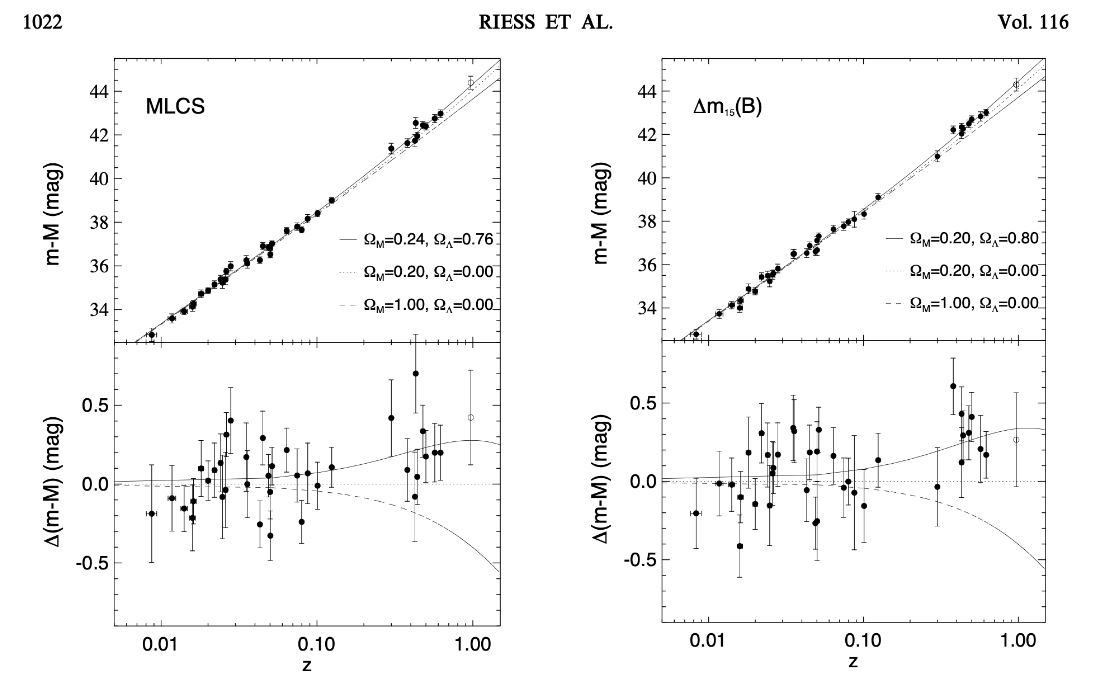

These are some (synthetic but realistic; see textbook) supernova data

(35.0, 50.0)

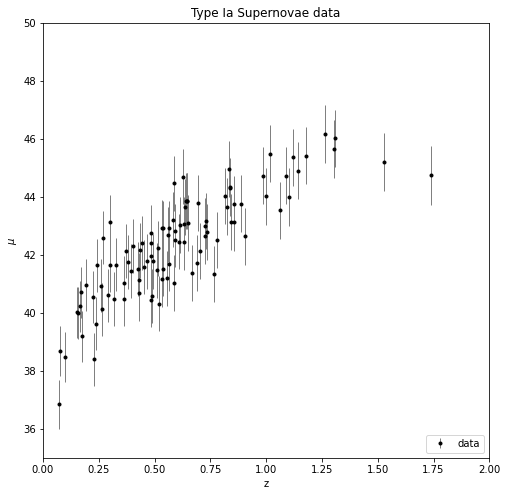

In [3]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

fig = plt.figure(figsize=(8,8))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Type Ia Supernovae data')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

###  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?

### Linear regression

In [4]:
# put the data in the correct format for sklearn:

X = z_sample[:,np.newaxis]
y = mu_sample[:,np.newaxis]
dy = dmu

[39.60456481] [[4.5911933]]


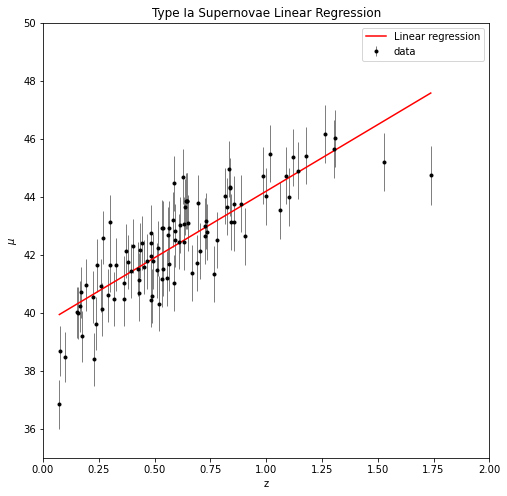

In [5]:
lin_reg = LinearRegression()
lin_reg.fit(X, y, sample_weight=dy)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)

X_grid = np.linspace(z_sample.min(),z_sample.max(),1000)[:,np.newaxis]
y_pred = lin_reg.predict(X_grid)

fig = plt.figure(figsize=(8,8))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(X_grid,y_pred,color='r',label='Linear regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Type Ia Supernovae Linear Regression')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()

### Polinomial regression

In [6]:
# put the data in the correct format for astroML:

X = z_sample[:,np.newaxis]
y = mu_sample
dy = dmu

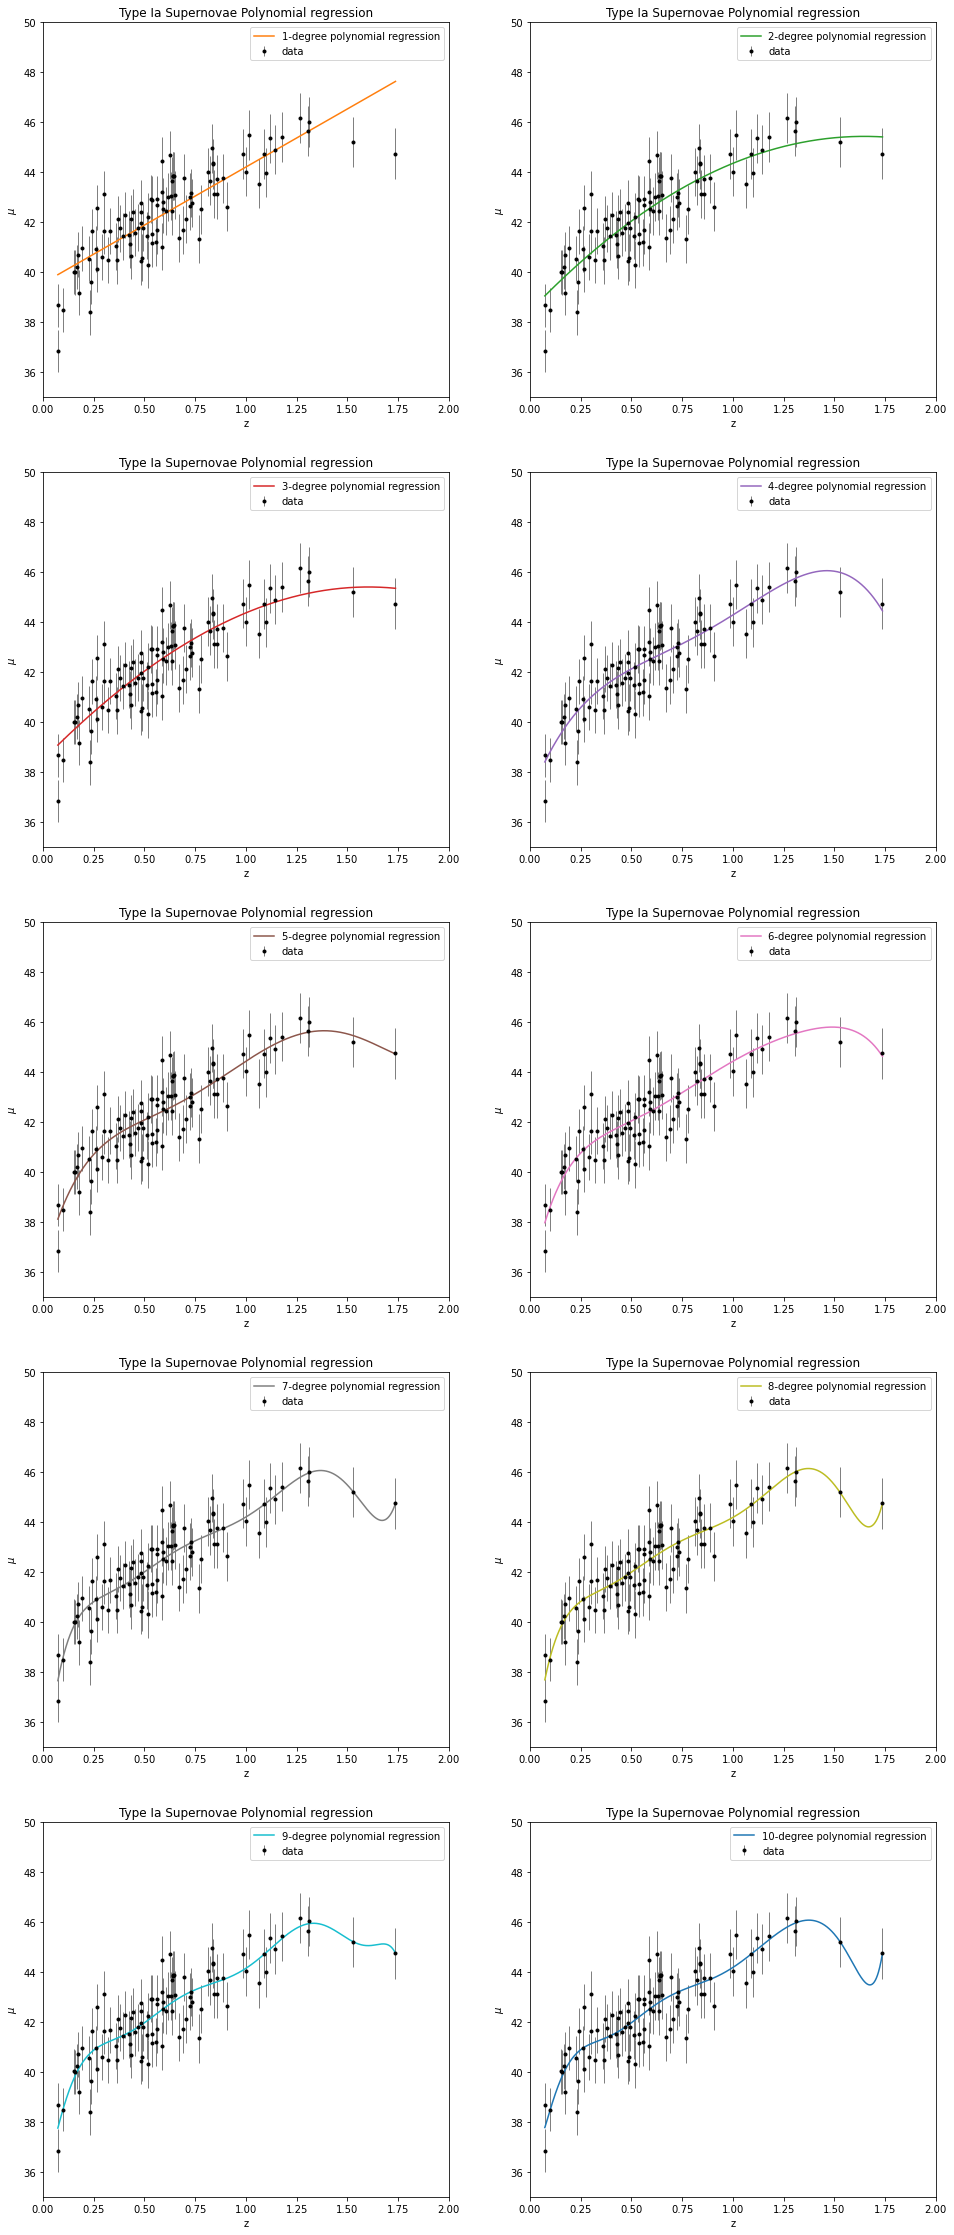

In [7]:
n_degree = np.arange(1,11)

ncols=2
nrows=5

fig,axis = plt.subplots(ncols=ncols,nrows=nrows,figsize=(ncols*8,nrows*8))

for n,ax in zip(n_degree,axis.flatten()):
    model = PolynomialRegression(n)
    model.fit(X,y)
    y_pred = model.predict(X_grid)
    
    ax.plot(X_grid,y_pred,label='%i-degree polynomial regression'%n,color='C%i'%n)
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
    ax.set_xlabel("z")
    ax.set_ylabel("$\mu$")
    ax.set_title('Type Ia Supernovae Polynomial regression')
    ax.legend(loc='lower right')
    ax.set_xlim(0,2)
    ax.set_ylim(35,50)
    ax.legend()


- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Implement the cross-validation error function
- Compute the cross-validation error for each model
- Pick the best!
- Does it agree with our bets?
- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [37]:
def error_func(y_true, y_m):
    N = len(y_true)
    return np.sqrt(1/N * np.sum((y_true-y_m)**2)) # implement the division by the sigma?

#### K-Folds

N_splits: 5
Best n_deg: 2


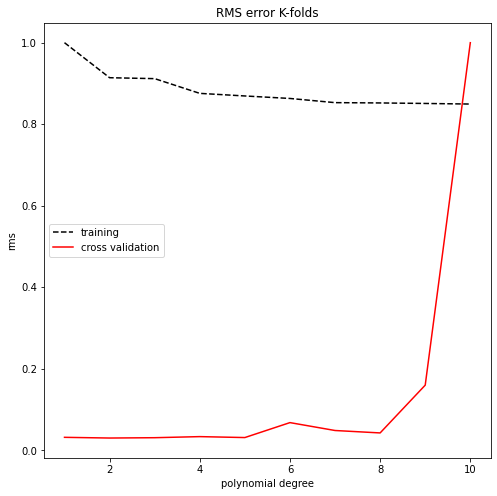

In [171]:
n_degree = np.arange(1,11)

err_cv = np.zeros(len(n_degree))
err_train = np.zeros(len(n_degree))

for deg in n_degree:
    model = PolynomialRegression(deg)
    
    # cross validation
    n_splits = 5
    kf = KFold(n_splits=n_splits) # sample splitting
    
    err2_train_i = []
    err2_cv_i = []
    
    # iterating over the n_splits
    for train, test in kf.split(X):
        
        # define the model given the splitted data
        model.fit(X[train],y[train]) 
        
        #define the variables to compute the errors
        y_train = model.predict(X[train])
        y_cv = model.predict(X[test])
        y_true_train = y[train]
        y_true_cv = y[test]
        
        # compute the errors on the training and cross-validation set for a given set
        err2_train_i.append((error_func(y_true_train,y_train))**2) # take the square to sum
        err2_cv_i.append((error_func(y_true_cv,y_cv))**2) # take the square to sum
        
    err_train[deg-1] = np.sqrt(np.sum(err2_train_i))
    err_cv[deg-1] = np.sqrt(np.sum(err2_cv_i))
    
print('N_splits:',n_splits)

# normalization of the error
norm_err_cv = err_cv/err_cv.max()
norm_err_train = err_train/err_train.max()

print('Best n_deg:',np.argmin(norm_err_cv)+1)

# plot
fig = plt.figure(figsize=(8,8))

plt.plot(n_degree,norm_err_train,color='black',ls='--',label='training')
#plt.scatter(n_degree,norm_err_train,color='black')
plt.plot(n_degree,norm_err_cv,color='red',ls='-',label='cross validation')
plt.xlabel('polynomial degree')
plt.ylabel('rms')
plt.title('RMS error K-folds')
plt.legend()

#### Leave one out

Best n_deg: 5


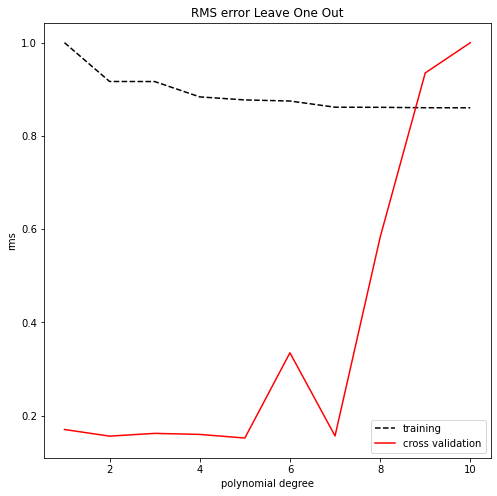

In [170]:
n_degree = np.arange(1,11)

err_cv = np.zeros(len(n_degree))
err_train = np.zeros(len(n_degree))

for deg in n_degree:
    model = PolynomialRegression(deg)
    
    # cross validation
    loo = LeaveOneOut() # sample splitting
    
    err2_train_i = []
    err2_cv_i = []
    
    # iterating over the n_splits
    for train, test in loo.split(X):
        
        # define the model given the splitted data
        model.fit(X[train],y[train]) 
        
        #define the variables to compute the errors
        y_train = model.predict(X[train])
        y_cv = model.predict(X[test])
        y_true_train = y[train]
        y_true_cv = y[test]
        
        # compute the errors on the training and cross-validation set for a given set
        err2_train_i.append((error_func(y_true_train,y_train))**2) # take the square to sum
        err2_cv_i.append((error_func(y_true_cv,y_cv))**2) # take the square to sum
        
    err_train[deg-1] = np.sqrt(np.sum(err2_train_i))
    err_cv[deg-1] = np.sqrt(np.sum(err2_cv_i))
    

# normalization of the error
norm_err_cv = err_cv/err_cv.max()
norm_err_train = err_train/err_train.max()

print('Best n_deg:',np.argmin(norm_err_cv)+1)

# plot
fig = plt.figure(figsize=(8,8))

plt.plot(n_degree,norm_err_train,color='black',ls='--',label='training')
plt.plot(n_degree,norm_err_cv,color='red',ls='-',label='cross validation')
plt.xlabel('polynomial degree')
plt.ylabel('rms')
plt.title('RMS error Leave One Out')
plt.legend()

#### Single splitting

Best n_deg: 7


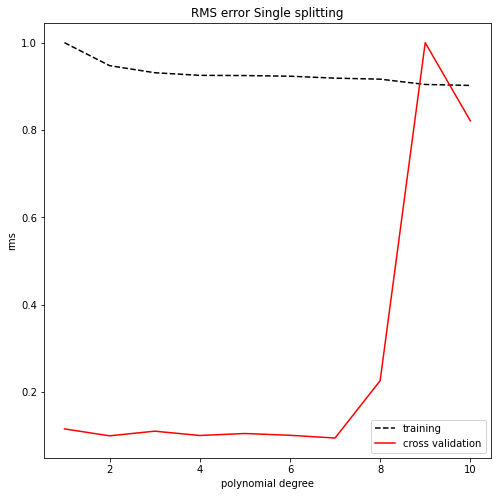

In [172]:
err_cv = np.zeros(len(n_degree))
err_train = np.zeros(len(n_degree))

# split the data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.25,train_size=0.75)


for deg in n_degree:
    model = PolynomialRegression(deg)
    model.fit(X_train,y_train)
    
    y_cv = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    err_cv[deg-1] = error_func(y_test,y_cv)
    err_train[deg-1] = error_func(y_train,y_train_pred)
    
# normalization of the error
norm_err_cv = err_cv/err_cv.max()
norm_err_train = err_train/err_train.max()

print('Best n_deg:',np.argmin(norm_err_cv)+1)

#plot
fig = plt.figure(figsize=(8,8))

plt.plot(n_degree,norm_err_train,color='black',ls='--',label='training')
plt.plot(n_degree,norm_err_cv,color='red',ls='-',label='cross validation')
plt.xlabel('polynomial degree')
plt.ylabel('rms')
plt.title('RMS error Single splitting')
plt.legend()

#### Single splitting iteration

100%|██████████| 100/100 [00:01<00:00, 80.56it/s]


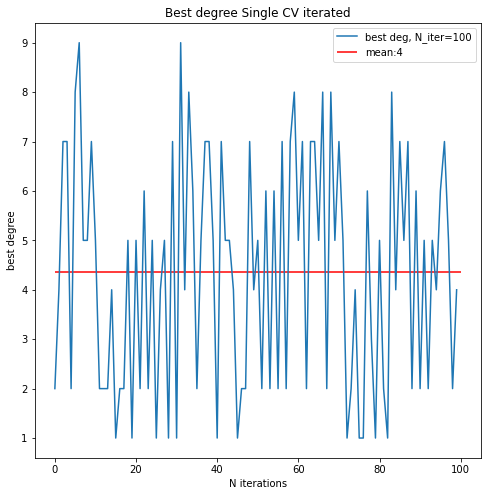

In [188]:
N_iter = 100
best_deg = np.zeros(N_iter)    
    
for i in tqdm(range(N_iter)):
    err_cv = np.zeros(len(n_degree))
    err_train = np.zeros(len(n_degree))

    # split the data
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.25,train_size=0.75)


    for deg in n_degree:
        model = PolynomialRegression(deg)
        model.fit(X_train,y_train)
        
        y_cv = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        
        err_cv[deg-1] = error_func(y_test,y_cv)
        err_train[deg-1] = error_func(y_train,y_train_pred)
        
    # normalization of the error
    norm_err_cv = err_cv/err_cv.max()
    norm_err_train = err_train/err_train.max()

    best_deg[i] = np.argmin(norm_err_cv)+1

mode_best_deg = scipy.stats.mode(best_deg)
mean_best_deg = np.mean(best_deg)
    
# plot
fig = plt.figure(figsize=(8,8))
plt.plot(best_deg,label='best deg, N_iter=%i'%N_iter)
plt.xlabel('N iterations')
plt.ylabel('best degree')
plt.title('Best degree Single CV iterated')
plt.hlines(mean_best_deg,0,N_iter,color='red',label='mean:%i'%int(mean_best_deg))
plt.legend()

### Learning curves

In [192]:
final_best_deg = 4

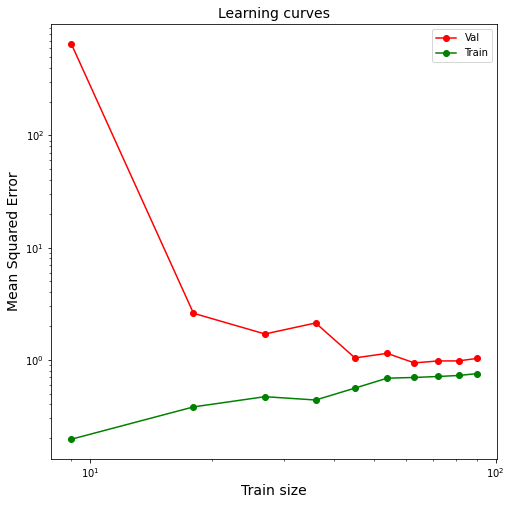

In [196]:
# model
pol_reg = PolynomialRegression(final_best_deg)

# learning curves
train_sizes, train_scores_linreg, test_scores_linreg = \
    learning_curve(pol_reg, X, y, train_sizes=np.linspace(0.1, 1, 10), \
    scoring="neg_mean_squared_error", cv=10)

fig = plt.figure(figsize=(8, 8))

plt.plot(train_sizes, -test_scores_linreg.mean(1), 'o-', color="r", label="Val")
plt.plot(train_sizes, -train_scores_linreg.mean(1), 'o-', color="g", label="Train")
                   
plt.xlabel("Train size",fontsize=14)
plt.ylabel("Mean Squared Error",fontsize=14)
plt.title('Learning curves',fontsize=14)
plt.legend(loc="best")
#plt.ylim(0,200)
plt.xscale('log')
plt.yscale('log')

### Basis function regression


In [ ]:
mu = np.linspace(0.01,1,100)
sigma = 0.1

# mean positions of the 10 Gaussians in the model
X_gridtest = np.linspace(0,1,10)[:, None]
# widths of these Gaussians
sigma_test = 0.1

model = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=sigma_test)
model.fit(Xtest, ytest, dytest)

y_pred = model.predict(Xtest)
print(model.coef_)

### Kernel regression

Best h: 0.04


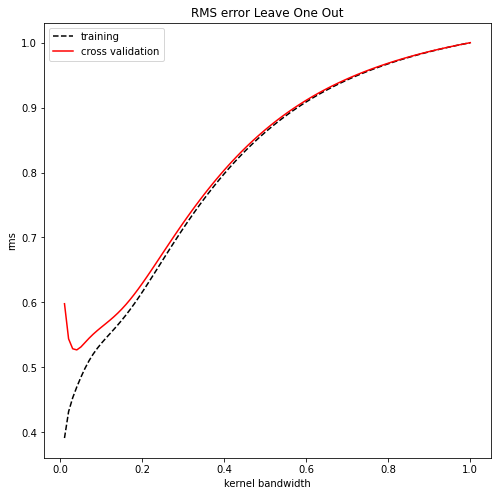

In [210]:
h_vec = np.linspace(0.01,1,100)

err_cv = np.zeros(len(h_vec))
err_train = np.zeros(len(h_vec))

for h,i in zip(h_vec,np.arange(0,len(h_vec))):
    model = NadarayaWatson(kernel='gaussian', h=h)
    
    # cross validation
    loo = LeaveOneOut() # sample splitting
    
    err2_train_i = []
    err2_cv_i = []
    
    # iterating over the n_splits
    for train, test in loo.split(X):
        
        # define the model given the splitted data
        model.fit(X[train],y[train]) 
        
        #define the variables to compute the errors
        y_train = model.predict(X[train])
        y_cv = model.predict(X[test])
        y_true_train = y[train]
        y_true_cv = y[test]
        
        # compute the errors on the training and cross-validation set for a given set
        err2_train_i.append((error_func(y_true_train,y_train))**2) # take the square to sum
        err2_cv_i.append((error_func(y_true_cv,y_cv))**2) # take the square to sum
        
    err_train[i] = np.sqrt(np.sum(err2_train_i))
    err_cv[i] = np.sqrt(np.sum(err2_cv_i))

# normalization of the error
norm_err_cv = err_cv/err_cv.max()
norm_err_train = err_train/err_train.max()

print('Best h:',h_vec[np.argmin(norm_err_cv)])

# plot
fig = plt.figure(figsize=(8,8))

plt.plot(h_vec,norm_err_train,color='black',ls='--',label='training')
plt.plot(h_vec,norm_err_cv,color='red',ls='-',label='cross validation')
plt.xlabel('kernel bandwidth')
plt.ylabel('rms')
plt.title('RMS error Leave One Out')
plt.legend()

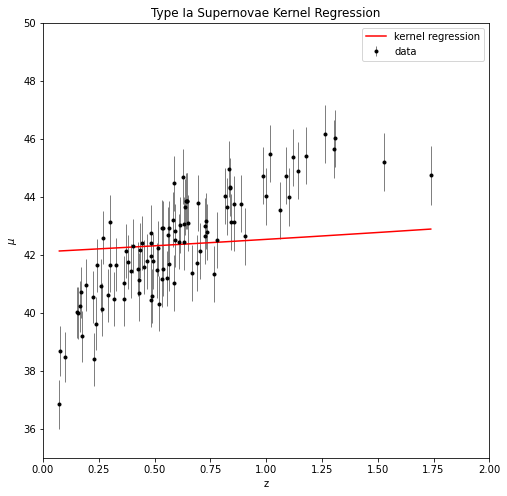

In [219]:
model_best_kernel = NadarayaWatson(kernel='gaussian', h=h_vec[np.argmin(norm_err_cv)])

model_best_kernel.fit(X,y)

y_pred_best_kernel = model.predict(X_grid)

fig = plt.figure(figsize=(8,8))
plt.plot(X_grid,y_pred_best_kernel,color='red',label='kernel regression')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Type Ia Supernovae Kernel Regression')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()